In [30]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.optimize

from sublimpy import tidy


import altair as alt
alt.data_transformers.enable('json') 
import matplotlib.pyplot as plt

# Inputs

In [31]:
start_date = '20221130'
end_date = '20230509'
sos_download_dir = '/data2/elilouis/sublimationofsnow/sosnoqc'

In [32]:
try:
    tidy_df_5Min = pd.read_parquet(f"../sos/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])

# M.O.S.T. Scheme

We adapt a scheme described by Marks and Dozier (1992, see Equations 9 - 16), in which we solve a system of equations using a limited number of measurements. Our method differs in that we assume a constant measurement height for all measurements throughout our measurement period, even though the snow surface varys from 0 to 2 meters during the snow season. Note that our method differs from theirs in that we calculate momentum, sensible heat, and latent heat fluxes as positive AWAY from the surface.

We define 4 equations we want to solve, which correspond to 4 dependent variables. We also define stability functions for stable and unstable conditions (see the code).


*Marks, D., & Dozier, J. (1992). Climate and energy exchange at the snow surface in the Alpine Region of the Sierra Nevada: 2. Snow cover energy balance. Water Resources Research, 28(11), 3043–3054. https://doi.org/10.1029/92WR01483*

## Define Constants

In [33]:
VON_KARMAN_CONSTANT = 0.40 #dimensionless
GRAVITY = 9.81 # m/s^2
SNOW_SURFACE_ROUGHNESS = 1e-4 # m, Marks and Dozier report its in the range [1e-4, 5e-3]
ZERO_PLANE_DISPLACEMENT_HEIGHT = (2/3)*7.35*SNOW_SURFACE_ROUGHNESS # m
RATIO_OF_EDDY_DIFFUSIVITY_AND_VISCOSITY_FOR_HEAT = 1.0 # dimensionless
RATIO_OF_EDDY_DIFFUSIVITY_AND_VISCOSITY_FOR_WATERVAPOR = 1.0 # dimensionless
AIR_SPECIFIC_HEAT = 1005 # J / kg / K

## Extract variables

In [34]:
VARIABLES = [
    'spd_3m_c',
    'Tpot_3m_c',
    'Tsurfpot_rad_c',
    'mixingratio_3m_c',
    'Tsurfmixingratio_rad_c',
    'airdensity_3m_c',
    'T_3m_c',
    'w_h2o__3m_c',
    'w_tc__3m_c',
    'u*_3m_c',

    'Tsurf_rad_d',
    'P_10m_c'
]

[ v for v in tidy_df_5Min.variable.unique() if v in VARIABLES ]

['w_h2o__3m_c',
 'spd_3m_c',
 'T_3m_c',
 'w_tc__3m_c',
 'P_10m_c',
 'Tsurf_rad_d',
 'Tpot_3m_c',
 'airdensity_3m_c',
 'mixingratio_3m_c',
 'Tsurfmixingratio_rad_c',
 'Tsurfpot_rad_c',
 'u*_3m_c']

In [35]:
variables_df = tidy_df_5Min[tidy_df_5Min.variable.isin(VARIABLES)].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()

## Make necessary conversions

In [36]:
# convert from ˚C to K
variables_df['T_3m_c'] = variables_df['T_3m_c'] + 273.15
variables_df['Tpot_3m_c'] = variables_df['Tpot_3m_c'] + 273.15
variables_df['Tsurfpot_rad_c'] = variables_df['Tsurfpot_rad_c'] + 273.15
variables_df['Tsurf_rad_d'] = variables_df['Tsurf_rad_d'] + 273.15

# convert from g/g to g/kg
variables_df['mixingratio_3m_c'] = variables_df['mixingratio_3m_c']*1000
variables_df['Tsurfmixingratio_rad_c'] = variables_df['Tsurfmixingratio_rad_c']*1000

## Add measurement height variables (constants)

In [37]:
variables_df['measurement_height_windspeed'] = 3
variables_df['measurement_height_temperature'] = 3
variables_df['measurement_height_specifichumidity'] = 3

# Shrink Dataset

In [38]:
# variables_df = variables_df.iloc[:50]

# Define 7 equations (to be solved)

In [39]:
## 3 helper functions
def stable_stability_function_generic(
    zeta # dimensionless
):
    return -5

def x_func(
    zeta # dimensionless
):
    return (1 - 16*zeta)**(0.25)

def unstable_stability_function_heat_and_watervapor(
    zeta # dimensionless
):
    return 2*np.log(
        (1 + x_func(zeta)**2) / 2)

## Class to hold the 7 functions that require solving
class MOST:
    
    def obukhov_stability_length(
        self,
        friction_velocity, # m/s 
        air_density, # kg/m^3 
        sensible_heat_flux, # W/m^2
        air_temperature, # K
        latent_heat_flux # kg/m^2/s
    ):
        """
        Returns Obukhov stability length, units of m.
        """
        return (
            (friction_velocity**3)*air_density
        ) / (
            VON_KARMAN_CONSTANT * GRAVITY * (
                (sensible_heat_flux / (air_temperature * AIR_SPECIFIC_HEAT))
                +
                0.61 * latent_heat_flux
            )
        )

    def friction_velocity(
        self,
        wind_speed, # m/s 
        measurement_height_above_snow_surface_windspeed, # of wind speed measurement, m
        stability_function_mass
    ):
        """
        Returns friction velocity, units of m/s.
        """
        return (
            wind_speed * VON_KARMAN_CONSTANT
        ) / (
            np.log(
                (measurement_height_above_snow_surface_windspeed - ZERO_PLANE_DISPLACEMENT_HEIGHT) / SNOW_SURFACE_ROUGHNESS
            )
            -
            stability_function_mass
        )

    def sensible_heat_flux(
        self,
        air_potential_temperature, # K
        snow_surface_potential_temperature, # K
        friction_velocity, # m/s
        air_density, # kg/m^3
        measurement_height_above_snow_surface_temperature, # of temperature measurement, m
        stability_function_heat # m
    ):
        """
        Returns sensible heat flux, positive away from the surface, units of W/m^2.
        """
        return - (
            (air_potential_temperature - snow_surface_potential_temperature)
            *
            RATIO_OF_EDDY_DIFFUSIVITY_AND_VISCOSITY_FOR_HEAT
            *
            VON_KARMAN_CONSTANT*friction_velocity*air_density*AIR_SPECIFIC_HEAT
        ) / (
            np.log(
                (measurement_height_above_snow_surface_temperature - ZERO_PLANE_DISPLACEMENT_HEIGHT) / SNOW_SURFACE_ROUGHNESS
            )
            -
            stability_function_heat
        )

    def latent_heat_flux(
        self,
        air_specific_humidity, # g / kg
        snow_surface_specific_humidity, # g / kg
        friction_velocity, # m/s
        air_density, # kg/m^3
        measurement_height_above_snow_surface_specifichumidity, # of specific humidity measurement
        stability_function_watervapor
    ):
        """
        Returns latent heat flux, positive away from the surface, units of kg/m^2/s.
        """
        return - (
            (air_specific_humidity - snow_surface_specific_humidity)
            *
            RATIO_OF_EDDY_DIFFUSIVITY_AND_VISCOSITY_FOR_WATERVAPOR
            *
            VON_KARMAN_CONSTANT*friction_velocity*air_density
        ) / (
            np.log(
                (measurement_height_above_snow_surface_specifichumidity - ZERO_PLANE_DISPLACEMENT_HEIGHT) / SNOW_SURFACE_ROUGHNESS
            )
            -
            stability_function_watervapor
        )

    def stability_function_mass(
        self,
        measurement_height_above_snow_surface_windspeed,
        obukhov_stability_length
    ):
        zeta = measurement_height_above_snow_surface_windspeed / obukhov_stability_length
        if zeta > 0:
            return stable_stability_function_generic(zeta)
        else:
            return 2*np.log(
                (1 + x_func(zeta)) / 2
            ) + np.log(
                (1 + x_func(zeta)**2) / 2
            ) - 2*np.arctan(
                x_func(zeta)
            ) + np.pi/2

    def stability_function_heat(
        self,
        measurement_height_above_snow_surface_temperature,
        obukhov_stability_length
    ):
        zeta = measurement_height_above_snow_surface_temperature / obukhov_stability_length
        if zeta > 0:
            return stable_stability_function_generic(zeta)
        else:
            return unstable_stability_function_heat_and_watervapor(zeta)

    def stability_function_watervapor(
        self,
        measurement_height_above_snow_surface_specifichumidity,
        obukhov_stability_length
    ):
        zeta = measurement_height_above_snow_surface_specifichumidity / obukhov_stability_length
        if zeta > 0:
            return stable_stability_function_generic(zeta)
        else:
            return unstable_stability_function_heat_and_watervapor(zeta)

    # this works for all three - momentum, heat, and water vapor
    def stability_function_holtslag_debruin(
            self,
            measurement_height_above_snow_surface_specifichumidity,
            obukhov_stability_length
    ):
        zeta = measurement_height_above_snow_surface_specifichumidity / obukhov_stability_length
        a = 0.7
        b = 0.75
        c = 5
        d = 0.35
        return -a*zeta - b*(zeta - c/d)*np.exp(-d*zeta) - b*c/d

# Use SciPy Solver

We define 4 equations we want to solve, which correspond to 4 dependent variables. We also define stability functions for stable and unstable conditions (see the code).

**DEPENDENT VARIABLES**
```
obukhov_stability_length        # m
friction_velocity               # m/s 
sensible_heat_flux              # W/m^2
latent_heat_flux                # kg/m^2/s
stability_function_mass
stability_function_heat
stability_function_watervapor
```

We provide measurements for the following variables.

**INDEPENDENT VARIABLES**
```
measurement_height_above_snow_surface_windspeed         # m
measurement_height_above_snow_surface_temperature       # m
measurement_height_above_snow_surface_specifichumidity  # m
wind_speed                                              # m/s 
air_potential_temperature                               # K
snow_surface_potential_temperature                      # K
air_specific_humidity                                   # g / kg
snow_surface_specific_humidity                          # g / kg
air_density                                             # kg/m^3 
air_temperature                                         # K
```

In [40]:
# instatiate MOST class
most = MOST()

## Test on one timestep

In [41]:
variable_set = variables_df.iloc[31000]

L = lambda obukhov_stability_length, friction_velocity, sensible_heat_flux, latent_heat_flux: -obukhov_stability_length + most.obukhov_stability_length(
    friction_velocity, # m/s 
    variable_set['airdensity_3m_c'], # kg/m^3 
    sensible_heat_flux, # W/m^2
    variable_set['T_3m_c'], # K
    latent_heat_flux # kg/m^2/s
)

u_friction = lambda friction_velocity, stability_function_mass: -friction_velocity + most.friction_velocity(
    variable_set['spd_3m_c'], # m/s 
    3, # of wind speed measurement, m
    stability_function_mass
)

H = lambda sensible_heat_flux, friction_velocity, stability_function_heat: -sensible_heat_flux + most.sensible_heat_flux(
    variable_set['Tpot_3m_c'], # K
    variable_set['Tsurfpot_rad_c'], # K
    friction_velocity, # m/s
    variable_set['airdensity_3m_c'], # kg/m^3
    3, # of temperature measurement, m
    stability_function_heat # m
)

E = lambda latent_heat_flux, friction_velocity, stability_function_watervapor: -latent_heat_flux + most.latent_heat_flux(
    variable_set['mixingratio_3m_c'], # g / kg
    variable_set['Tsurfmixingratio_rad_c'], # g / kg
    friction_velocity, # m/s
    variable_set['airdensity_3m_c'], # kg/m^3
    3, # of specific humidity measurement
    stability_function_watervapor
)

Phi_m = lambda stability_function_mass, obukhov_stability_length: -stability_function_mass + most.stability_function_mass(
    3,
    obukhov_stability_length
)

Phi_H = lambda stability_function_heat, obukhov_stability_length: -stability_function_heat + most.stability_function_heat(
    3,
    obukhov_stability_length
)

Phi_E = lambda stability_function_watervapor, obukhov_stability_length: -stability_function_watervapor + most.stability_function_watervapor(
    3,
    obukhov_stability_length
)

def eq(p):
    obukhov_stability_length, friction_velocity, sensible_heat_flux, latent_heat_flux, \
        stability_function_mass, stability_function_heat, stability_function_watervapor = p
    return (
        L(latent_heat_flux, friction_velocity, sensible_heat_flux, latent_heat_flux),
        u_friction(friction_velocity, stability_function_mass),
        H(sensible_heat_flux, friction_velocity, stability_function_heat),
        E(latent_heat_flux, friction_velocity, stability_function_watervapor),
        Phi_m(stability_function_mass, obukhov_stability_length),
        Phi_H(stability_function_heat, obukhov_stability_length),
        Phi_E(stability_function_watervapor, obukhov_stability_length)
    )

# obukhov_stability_length, friction_velocity, sensible_heat_flux, latent_heat_flux, \
    #        stability_function_mass, stability_function_heat, stability_function_watervapor
last_good_guess = (0.1, 0.1, -1, -0.001, 1.0, 1.0, 1.0)

# Run minimize the function
result = scipy.optimize.root(
    eq,
    last_good_guess,
    method='lm' # 'hybr' 'lm' 'broyden1' 'broyden2' 'anderson' 'linearmixing' 'diagbroyden' 'excitingmixing' 'krylov' 'df-sane'
)

## Test all solution methods (on one timestep)

In [42]:
for method in ['hybr', 'lm', 'broyden1', 'broyden2', 'anderson', 'linearmixing', 'diagbroyden', 'excitingmixing', 'krylov', 'df-sane']:
    print(method)
    print("============")
    try: 
        result = scipy.optimize.root(
            eq,
            last_good_guess,
            method=method # 'hybr' 'lm' 'broyden1' 'broyden2' 'anderson' 'linearmixing' 'diagbroyden' 'excitingmixing' 'krylov' 'df-sane'
        )
        print(result)
        print()
        print()
    except Exception as exc:
        print("FAILED")
        print(exc)
        print()
        print()

hybr
 message: The iteration is not making good progress, as measured by the 
            improvement from the last five Jacobian evaluations.
 success: False
  status: 4
     fun: [-3.587e-02  6.877e-02 -3.467e-03  1.397e-03  5.396e-04
           -9.546e-03 -4.381e-09]
       x: [ 5.996e+06  5.131e-02 -9.058e+00 -1.446e-03 -5.001e+00
           -4.990e+00 -5.000e+00]
    nfev: 194
    fjac: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00 -5.662e-03 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ... -1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00 -1.000e+00]]
       r: [-0.000e+00 -2.195e+00 ...  0.000e+00  1.000e+00]
     qtf: [-3.610e-02 -3.571e-03  6.877e-02 -1.323e-03 -5.394e-04
            1.103e-02  4.350e-09]


lm
 message: Both actual and predicted relative reductions in the sum of squares
            are at most 0.000000
 success: True
  status: 1
     fun: [-8.552e-03  6.572e-03  7.775e-08  2.057e-

## Perform on all timestamps

In [43]:
results_list = []
roots_list = []

# obukhov_stability_length, friction_velocity, sensible_heat_flux, latent_heat_flux, \
    #        stability_function_mass, stability_function_heat, stability_function_watervapor
last_good_guess = np.array([0.1, 0.1, -1, -0.001, 1.0, 1.0, 1.0])

no_data_result = np.array([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])

for i in range(0, len(variables_df)):
    
    variable_set = variables_df.iloc[i]

    L = lambda obukhov_stability_length, friction_velocity, sensible_heat_flux, latent_heat_flux: -obukhov_stability_length + most.obukhov_stability_length(
        friction_velocity, # m/s 
        variable_set['airdensity_3m_c'], # kg/m^3 
        sensible_heat_flux, # W/m^2
        variable_set['T_3m_c'], # K
        latent_heat_flux # kg/m^2/s
    )

    u_friction = lambda friction_velocity, stability_function_mass: -friction_velocity + most.friction_velocity(
        variable_set['spd_3m_c'], # m/s 
        3, # of wind speed measurement, m
        stability_function_mass
    )

    H = lambda sensible_heat_flux, friction_velocity, stability_function_heat: -sensible_heat_flux + most.sensible_heat_flux(
        variable_set['Tpot_3m_c'], # K
        variable_set['Tsurfpot_rad_c'], # K
        friction_velocity, # m/s
        variable_set['airdensity_3m_c'], # kg/m^3
        3, # of temperature measurement, m
        stability_function_heat # m
    )

    E = lambda latent_heat_flux, friction_velocity, stability_function_watervapor: -latent_heat_flux + most.latent_heat_flux(
        variable_set['mixingratio_3m_c'], # g / kg
        variable_set['Tsurfmixingratio_rad_c'], # g / kg
        friction_velocity, # m/s
        variable_set['airdensity_3m_c'], # kg/m^3
        3, # of specific humidity measurement
        stability_function_watervapor
    )

    Phi_m = lambda stability_function_mass, obukhov_stability_length: -stability_function_mass + most.stability_function_mass(
        3,
        obukhov_stability_length
    )

    Phi_H = lambda stability_function_heat, obukhov_stability_length: -stability_function_heat + most.stability_function_heat(
        3,
        obukhov_stability_length
    )

    Phi_E = lambda stability_function_watervapor, obukhov_stability_length: -stability_function_watervapor + most.stability_function_watervapor(
        3,
        obukhov_stability_length
    )

    def eq(p):
        obukhov_stability_length, friction_velocity, sensible_heat_flux, latent_heat_flux, \
            stability_function_mass, stability_function_heat, stability_function_watervapor = p
        return (
            L(latent_heat_flux, friction_velocity, sensible_heat_flux, latent_heat_flux),
            u_friction(friction_velocity, stability_function_mass),
            H(sensible_heat_flux, friction_velocity, stability_function_heat),
            E(latent_heat_flux, friction_velocity, stability_function_watervapor),
            Phi_m(stability_function_mass, obukhov_stability_length),
            Phi_H(stability_function_heat, obukhov_stability_length),
            Phi_E(stability_function_watervapor, obukhov_stability_length)
        )
    
    try:
        # Run minimize the function
        result = scipy.optimize.root(
        # result, infodict, ier, mesg = scipy.optimize.fsolve(
            eq,
            last_good_guess,
            method='hybr'
        )
        # if the minimize function is succesful, add the fitted results to a list and update the "last good fguess"
        # if ier == 1:
        fitted_params = result.x
        results_list.append(fitted_params)
        roots_list.append(eq(fitted_params))
        last_good_guess = fitted_params
        # if the minimize function is not succesful, print out the problem message and append a list of np.nan
        # else:
            # print(f"Error encountered for i = {i}")
            # print(mesg)   
            # results_list.append(no_data_result)
            # roots_list.append(no_data_result)
    except Exception as exc:
        # If a failure happens during any of the above steps, report the failure and append a list of np.nan
        print(f"Failure encountered for i = {i}")
        print(exc)
        results_list.append(no_data_result)
        roots_list.append(no_data_result)

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >], dtype=object)

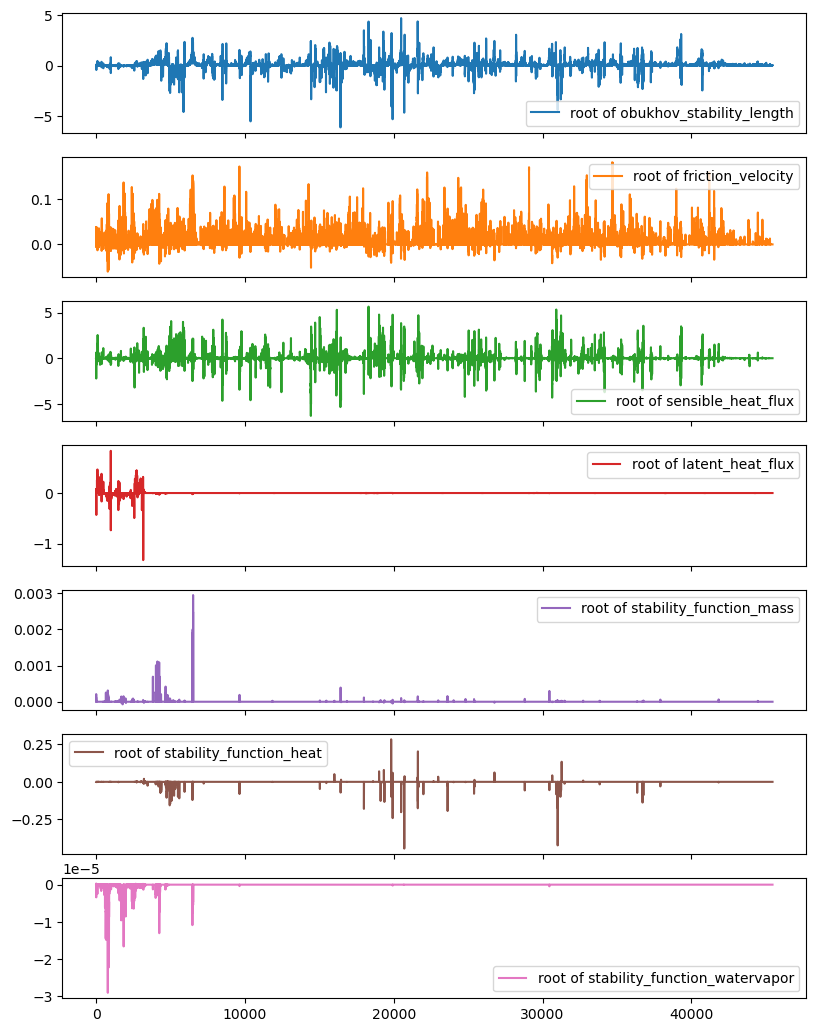

In [44]:
roots_df = pd.DataFrame(roots_list).rename(columns={
    0: 'root of obukhov_stability_length',
    1: 'root of friction_velocity',
    2: 'root of sensible_heat_flux',
    3: 'root of latent_heat_flux',
    4: 'root of stability_function_mass',
    5: 'root of stability_function_heat',
    6: 'root of stability_function_watervapor', 
})

roots_df.plot(subplots=True, figsize=(9.6, 12.8))

In [45]:
roots_isclose_df = roots_df.copy()
for col in roots_df.columns:
    roots_isclose_df[col] = np.isclose(roots_df[col], np.zeros(len(roots_df[col])))

In [46]:
for col in roots_isclose_df.columns:
    print(col)
    print(f"{len(roots_isclose_df[col].where(lambda x: x).dropna())} of {len(roots_isclose_df)}")
    print()


root of obukhov_stability_length
1 of 45460

root of friction_velocity
35494 of 45460

root of sensible_heat_flux
26175 of 45460

root of latent_heat_flux
35485 of 45460

root of stability_function_mass
43378 of 45460

root of stability_function_heat
42025 of 45460

root of stability_function_watervapor
42690 of 45460



In [47]:
results_df = pd.DataFrame(results_list).rename(columns={
    0: 'obukhov_stability_length',
    1: 'friction_velocity',
    2: 'sensible_heat_flux',
    3: 'latent_heat_flux',
    4: 'stability_function_mass',
    5: 'stability_function_heat',
    6: 'stability_function_watervapor', 
})
results_df

,obukhov_stability_length,friction_velocity,sensible_heat_flux,latent_heat_flux,stability_function_mass,stability_function_heat,stability_function_watervapor
0,2.572469e+04,0.059374,-2.779553,-0.001578,-5.000098,-4.999455,-5.000000
1,1.633775e+08,0.052711,-3.235037,-0.003817,-5.000061,-5.000142,-5.000000
2,1.880475e+11,0.046153,-3.790257,-0.005220,-5.000211,-5.000118,-5.000000
3,2.839518e+13,0.084036,-8.644106,-0.011339,-5.000100,-5.000020,-5.000000
4,2.705079e+14,0.098393,-11.371316,0.057074,-5.000000,-5.000903,-4.999997
...,...,...,...,...,...,...,...
45455,9.926263e+23,0.092878,-16.630898,0.009185,-5.000000,-5.000000,-5.000000
45456,9.926263e+23,0.079833,-13.310279,0.007519,-5.000000,-5.000000,-5.000000
45457,9.926263e+23,0.094879,-14.053654,0.008407,-5.000000,-5.000000,-5.000000
45458,9.926263e+23,0.081268,-13.106390,0.007403,-5.000000,-5.000000,-5.000000


In [48]:
merged_df = pd.merge(
    variables_df,
    results_df,
    left_index=True,
    right_index=True
)

Why does it seem like obukhov length is only correct after calculating it like this, after the fact??

In [49]:
merged_df['obukhov_stability_length_recalculated'] = merged_df.apply(
    lambda row: most.obukhov_stability_length(
        row['friction_velocity'],
        row['airdensity_3m_c'],
        row['sensible_heat_flux'],
        row['T_3m_c'],
        row['latent_heat_flux'] 
    ),
    axis=1
)

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >], dtype=object)

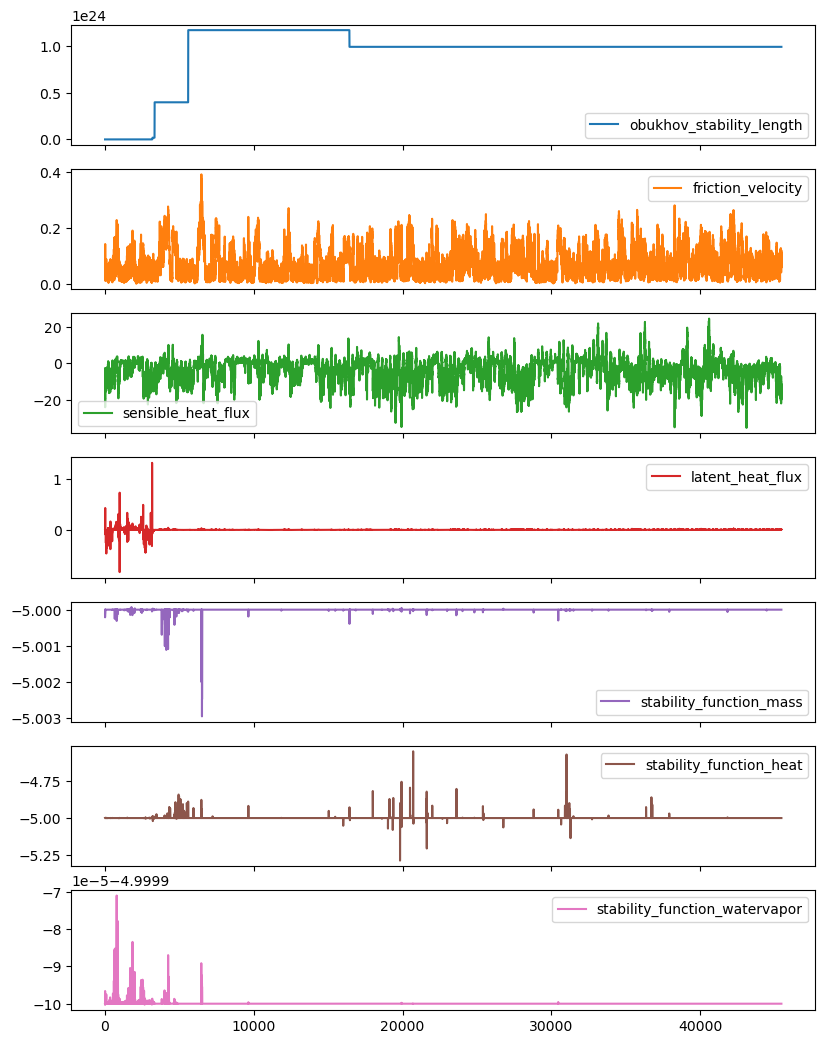

In [50]:
merged_df[[
    'obukhov_stability_length','friction_velocity','sensible_heat_flux','latent_heat_flux',
    'stability_function_mass','stability_function_heat','stability_function_watervapor'
]].plot(subplots=True, figsize=(9.6, 12.8))

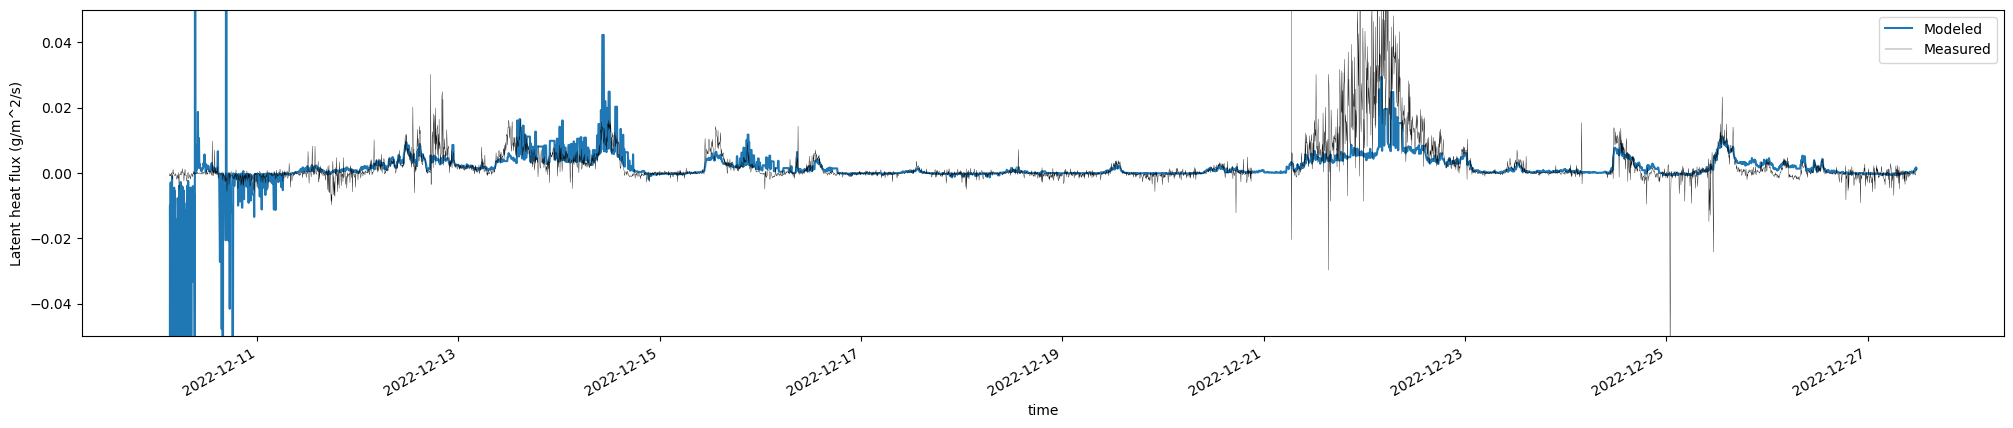

In [51]:
plt.figure(figsize=(24.8, 4.8))
merged_df.iloc[3000:8000].plot(x='time', y='latent_heat_flux', label='Modeled', ax = plt.gca())
merged_df.iloc[3000:8000].plot(x='time', y='w_h2o__3m_c', label='Measured', color='black', linewidth=0.25, ax = plt.gca())
plt.ylim(-0.05, 0.05)
plt.ylabel("Latent heat flux (g/m^2/s)")
plt.legend()

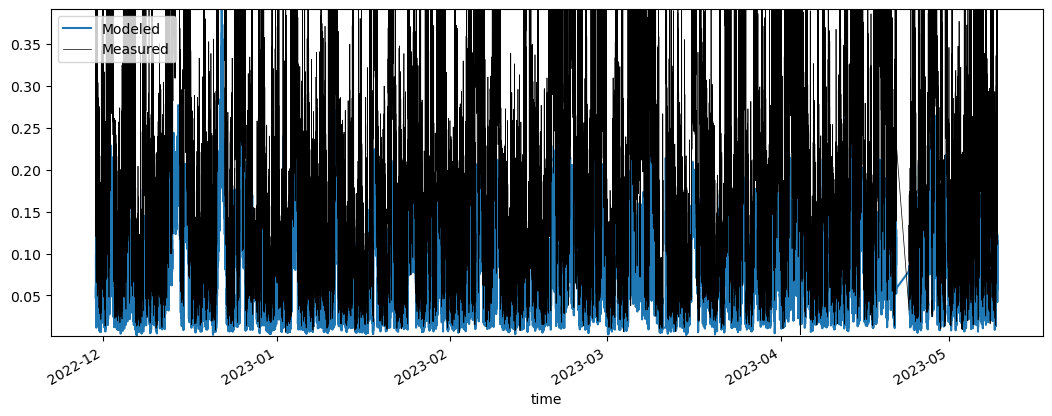

In [52]:
plt.figure(figsize=(12.8, 4.8))
merged_df.plot(x='time', y='friction_velocity', label='Modeled', ax = plt.gca())
merged_df.plot(x='time', y='u*_3m_c', label='Measured', color='black', linewidth=0.5, ax = plt.gca())
plt.ylim(merged_df['friction_velocity'].min(), merged_df['friction_velocity'].max())
plt.legend()

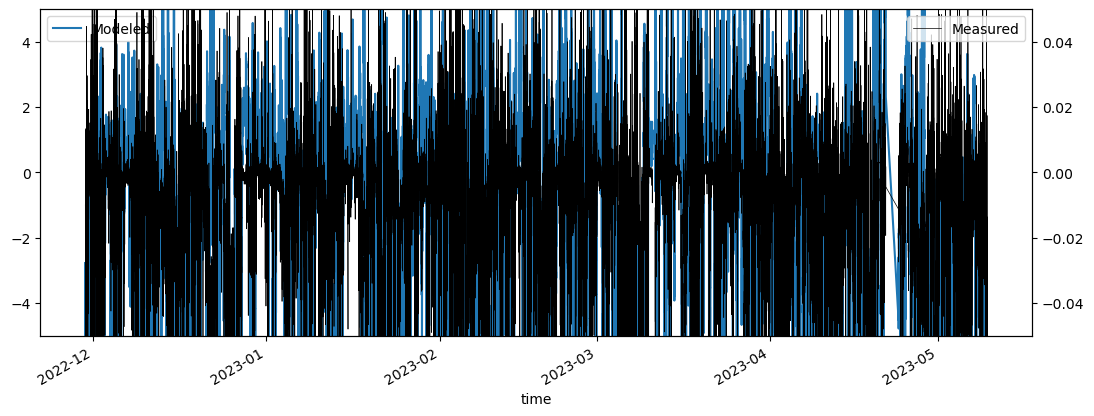

In [53]:
plt.figure(figsize=(12.8, 4.8))
merged_df.plot(x='time', y='sensible_heat_flux', label='Modeled', ax = plt.gca())
plt.gca().set_ylim(-5,5)
merged_df.plot(x='time', y='w_tc__3m_c', label='Measured', color='black', linewidth=0.5, ax = plt.twinx())
plt.gca().set_ylim(-0.05,0.05)

plt.legend()

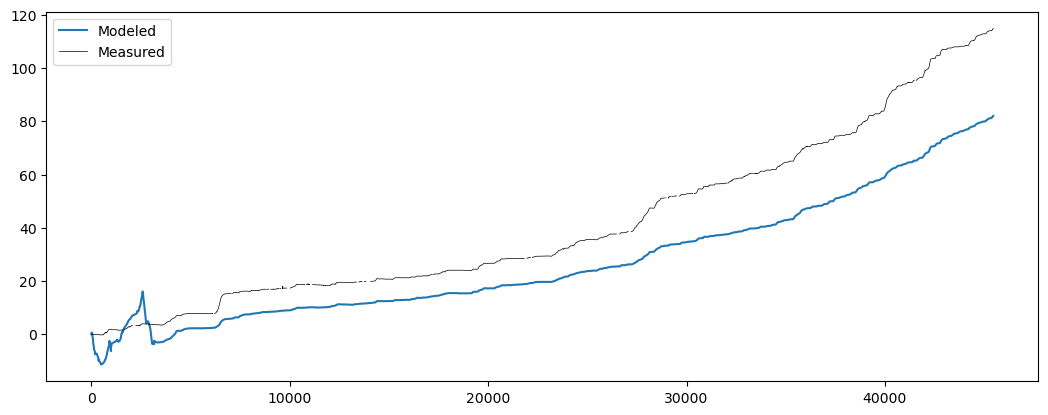

In [54]:
plt.figure(figsize=(12.8, 4.8))
merged_df['latent_heat_flux'].cumsum().plot(label='Modeled')
merged_df['w_h2o__3m_c'].cumsum().plot(label='Measured', color='black', linewidth=0.5)
plt.legend()

In [55]:
merged_df['Tpot_grad'] = (merged_df['Tpot_3m_c'] - merged_df['Tsurfpot_rad_c']) / 3
merged_df['mixingratio_grad'] = (merged_df['mixingratio_3m_c'] - merged_df['Tsurfmixingratio_rad_c']) / 3

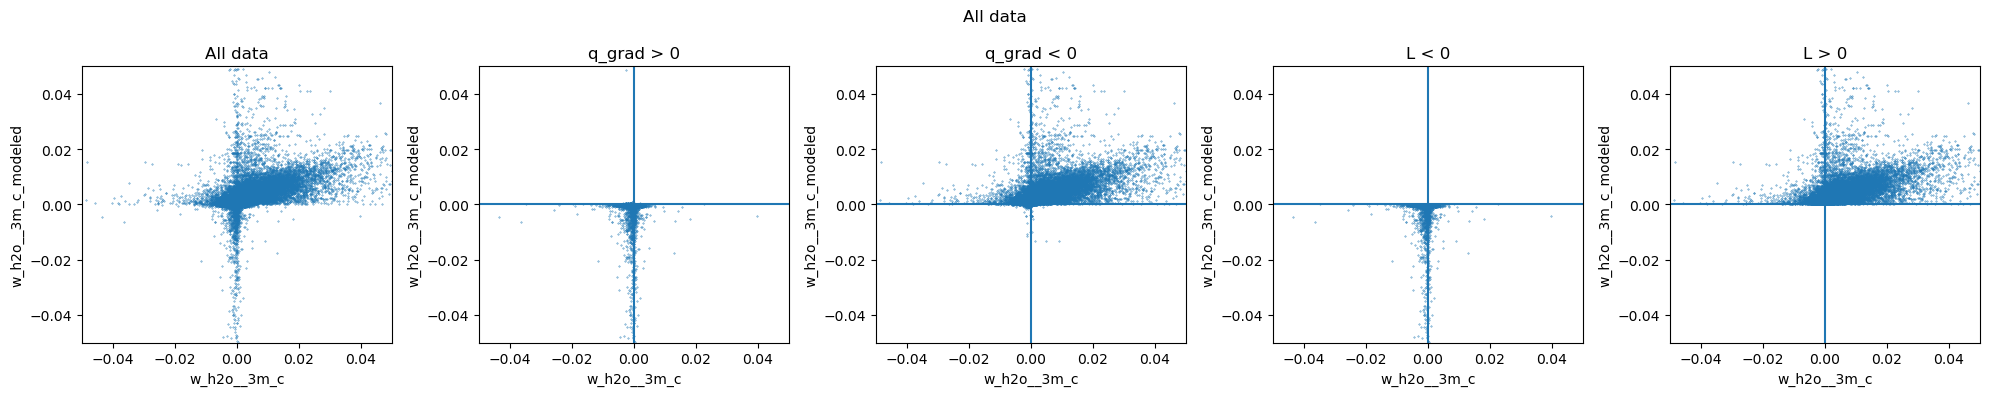

In [56]:
fig, axes = plt.subplots(1,5, figsize=(20,4))

# all data
axes[0].set_title("All data")
meas_src = merged_df['w_h2o__3m_c'],
model_src = merged_df['latent_heat_flux'],
axes[0].scatter(
    meas_src,
    model_src,
    s=0.1
)
axes[0].set_xlim(-0.05, 0.05)
axes[0].set_ylim(-0.05, 0.05)

# q gradient is positive (expected downward motion of water vapor)
axes[1].set_title("q_grad > 0")
src = merged_df.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("mixingratio_grad > 0")
axes[1].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[1].axvline(0)
axes[1].axhline(0)
axes[1].set_xlim(-0.05, 0.05)
axes[1].set_ylim(-0.05, 0.05)

# q gradient is negative (expected upward motion of water vapor)
axes[2].set_title("q_grad < 0")
src = merged_df.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("mixingratio_grad < 0")

axes[2].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[2].axvline(0)
axes[2].axhline(0)
axes[2].set_xlim(-0.05, 0.05)
axes[2].set_ylim(-0.05, 0.05)

# L < 0
axes[3].set_title("L < 0")
src = merged_df.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("obukhov_stability_length_recalculated < 0")

axes[3].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[3].axvline(0)
axes[3].axhline(0)
axes[3].set_xlim(-0.05, 0.05)
axes[3].set_ylim(-0.05, 0.05)

# L > 0
axes[4].set_title("L > 0")
src = merged_df.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("obukhov_stability_length_recalculated > 0")

axes[4].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[4].axvline(0)
axes[4].axhline(0)
axes[4].set_xlim(-0.05, 0.05)
axes[4].set_ylim(-0.05, 0.05)

for ax in axes:
    ax.set_xlabel('w_h2o__3m_c')
    ax.set_ylabel('w_h2o__3m_c_modeled')
plt.suptitle("All data")
plt.tight_layout()

Text(0.5, 0.98, 'No Blowing Snow')

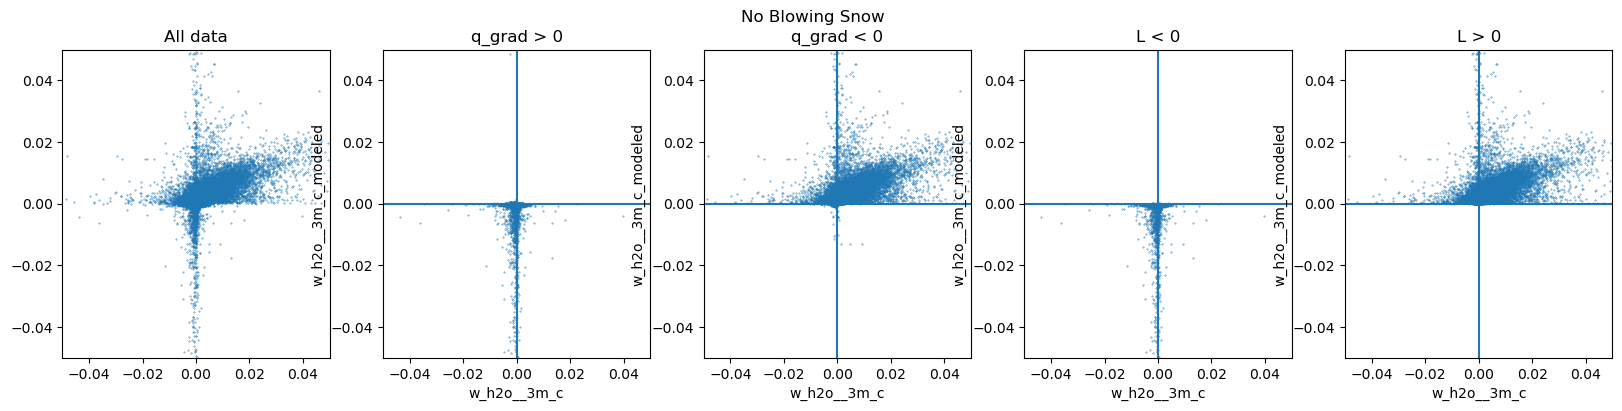

In [57]:
no_bs_times = tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").query("value == 0").time

merged_df_src = merged_df[merged_df.time.isin(no_bs_times)]

fig, axes = plt.subplots(1,5, figsize=(20,4))

# all data
axes[0].set_title("All data")
meas_src = merged_df_src['w_h2o__3m_c'],
model_src = merged_df_src['latent_heat_flux'],
axes[0].scatter(
    meas_src,
    model_src,
    s=0.1
)
axes[0].set_xlim(-0.05, 0.05)
axes[0].set_ylim(-0.05, 0.05)

# q gradient is positive (expected downward motion of water vapor)
axes[1].set_title("q_grad > 0")
src = merged_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("mixingratio_grad > 0")
axes[1].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[1].set_xlabel('w_h2o__3m_c')
axes[1].set_ylabel('w_h2o__3m_c_modeled')
axes[1].axvline(0)
axes[1].axhline(0)
axes[1].set_xlim(-0.05, 0.05)
axes[1].set_ylim(-0.05, 0.05)

# q gradient is negative (expected upward motion of water vapor)
axes[2].set_title("q_grad < 0")
src = merged_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("mixingratio_grad < 0")

axes[2].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[2].set_xlabel('w_h2o__3m_c')
axes[2].set_ylabel('w_h2o__3m_c_modeled')
axes[2].axvline(0)
axes[2].axhline(0)
axes[2].set_xlim(-0.05, 0.05)
axes[2].set_ylim(-0.05, 0.05)

# L < 0
axes[3].set_title("L < 0")
src = merged_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("obukhov_stability_length_recalculated < 0")

axes[3].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[3].set_xlabel('w_h2o__3m_c')
axes[3].set_ylabel('w_h2o__3m_c_modeled')
axes[3].axvline(0)
axes[3].axhline(0)
axes[3].set_xlim(-0.05, 0.05)
axes[3].set_ylim(-0.05, 0.05)

# L > 0
axes[4].set_title("L > 0")
src = merged_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("obukhov_stability_length_recalculated > 0")

axes[4].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[4].set_xlabel('w_h2o__3m_c')
axes[4].set_ylabel('w_h2o__3m_c_modeled')
axes[4].axvline(0)
axes[4].axhline(0)
axes[4].set_xlim(-0.05, 0.05)
axes[4].set_ylim(-0.05, 0.05)
plt.suptitle("No Blowing Snow")

Text(0.5, 0.98, 'Blowing Snow')

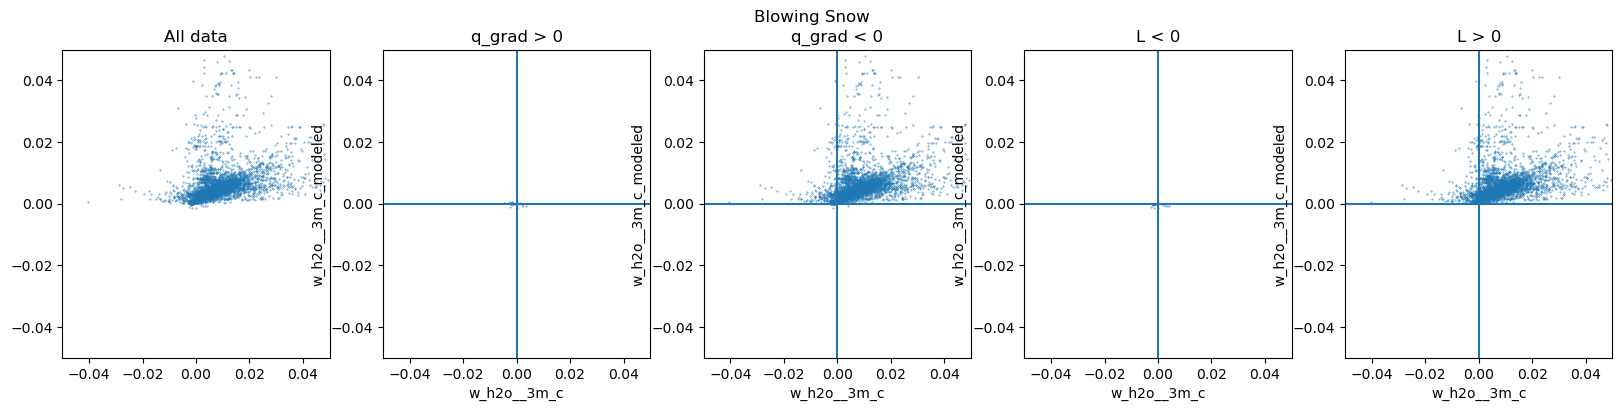

In [58]:
bs_times = tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").query("value > 0").time

merged_df_src = merged_df[merged_df.time.isin(bs_times)]

fig, axes = plt.subplots(1,5, figsize=(20,4))

# all data
axes[0].set_title("All data")
meas_src = merged_df_src['w_h2o__3m_c'],
model_src = merged_df_src['latent_heat_flux'],
axes[0].scatter(
    meas_src,
    model_src,
    s=0.1
)
axes[0].set_xlim(-0.05, 0.05)
axes[0].set_ylim(-0.05, 0.05)

# q gradient is positive (expected downward motion of water vapor)
axes[1].set_title("q_grad > 0")
src = merged_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("mixingratio_grad > 0")
axes[1].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[1].set_xlabel('w_h2o__3m_c')
axes[1].set_ylabel('w_h2o__3m_c_modeled')
axes[1].axvline(0)
axes[1].axhline(0)
axes[1].set_xlim(-0.05, 0.05)
axes[1].set_ylim(-0.05, 0.05)

# q gradient is negative (expected upward motion of water vapor)
axes[2].set_title("q_grad < 0")
src = merged_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("mixingratio_grad < 0")

axes[2].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[2].set_xlabel('w_h2o__3m_c')
axes[2].set_ylabel('w_h2o__3m_c_modeled')
axes[2].axvline(0)
axes[2].axhline(0)
axes[2].set_xlim(-0.05, 0.05)
axes[2].set_ylim(-0.05, 0.05)

# L < 0
axes[3].set_title("L < 0")
src = merged_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("obukhov_stability_length_recalculated < 0")

axes[3].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[3].set_xlabel('w_h2o__3m_c')
axes[3].set_ylabel('w_h2o__3m_c_modeled')
axes[3].axvline(0)
axes[3].axhline(0)
axes[3].set_xlim(-0.05, 0.05)
axes[3].set_ylim(-0.05, 0.05)

# L > 0
axes[4].set_title("L > 0")
src = merged_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("obukhov_stability_length_recalculated > 0")

axes[4].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[4].set_xlabel('w_h2o__3m_c')
axes[4].set_ylabel('w_h2o__3m_c_modeled')
axes[4].axvline(0)
axes[4].axhline(0)
axes[4].set_xlim(-0.05, 0.05)
axes[4].set_ylim(-0.05, 0.05)
plt.suptitle("Blowing Snow")

# Use TurbPy

In [60]:
from metpy.units import units
import turbpy
import sys
sys.path.append('/home/elilouis/sublimationofsnow/')
import sosutils

In [61]:
stab_titles, stab_methods, stab_dict = sosutils.get_turbpy_schemes()

In [62]:
stab_titles, stab_methods, stab_dict

(('Standard',
  'MO_HdB',
  'MO (Beljaars/Holtslag)',
  'MO (Webb - NoahMP)',
  'MO (Cheng/Brutsaert)'),
 {'Standard': 'standard',
  'MO_HdB': 'monin_obukhov',
  'MO (Beljaars/Holtslag)': 'monin_obukhov',
  'MO (Webb - NoahMP)': 'monin_obukhov',
  'MO (Cheng/Brutsaert)': 'monin_obukhov'},
 {'Standard': {'stability_method': 'standard'},
  'MO_HdB': {'stability_method': 'monin_obukhov',
   'monin_obukhov': {'gradient_function': 'holtslag_debruin'}},
  'MO (Beljaars/Holtslag)': {'stability_method': 'monin_obukhov',
   'monin_obukhov': {'gradient_function': 'beljaar_holtslag'}},
  'MO (Webb - NoahMP)': {'stability_method': 'monin_obukhov',
   'monin_obukhov': {'gradient_function': 'webb_noahmp'}},
  'MO (Cheng/Brutsaert)': {'stability_method': 'monin_obukhov',
   'monin_obukhov': {'gradient_function': 'cheng_brutsaert'}}})

In [63]:
height = 3
snowDepth = 0
fillna_method='ffill'

# collect inputs
sfcTemp = merged_df['Tsurf_rad_d'].fillna(method=fillna_method)    
airTemp = merged_df['T_3m_c'].fillna(method=fillna_method)
windspd = merged_df['spd_3m_c'].fillna(method=fillna_method)
airPressure = (merged_df['P_10m_c'].fillna(
    method=fillna_method
).values * units.millibar).to(units.pascal).magnitude
airVaporPress = turbpy.vapPress(
    (merged_df['mixingratio_3m_c']/1000).fillna(method=fillna_method),
    airPressure        
)
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.15)

In [64]:
## Calculate stability
# Initialzie dictionaries for containing output
stability_correction = {}
conductance_sensible = {}
conductance_latent = {}
sensible_heat = {}
latent_heat = {}
zeta = {}

for stab in stab_titles:
    stability_correction[stab] = np.zeros_like(sfcTemp)
    conductance_sensible[stab] = np.zeros_like(sfcTemp)
    conductance_latent[stab] = np.zeros_like(sfcTemp)
    sensible_heat[stab] = np.zeros_like(sfcTemp)
    latent_heat[stab] = np.zeros_like(sfcTemp)
    zeta[stab] = np.zeros_like(sfcTemp)

## Calculate stability
for stab in stab_titles:
    for n, (tair, vpair, tsfc, vpsfc, u, airP) in enumerate(zip(airTemp, airVaporPress, sfcTemp, sfcVaporPress, windspd, airPressure)):
        try:
            # Offline Turbulence Package
            (conductance_sensible[stab][n], 
            conductance_latent[stab][n], 
            sensible_heat[stab][n],
            latent_heat[stab][n],
            stab_output, p_test) = turbpy.turbFluxes(tair, airP,
                                                    vpair, u, tsfc,
                                                    vpsfc, snowDepth,
                                                    height, param_dict=stab_dict[stab],
                                                    z0Ground=SNOW_SURFACE_ROUGHNESS, groundSnowFraction=1)
            # Unpack stability parameters dictionary
            if not 'monin_obukhov' in stab_methods[stab]:
                stability_correction[stab][n] = stab_output['stabilityCorrection']
            else:
                stability_correction[stab][n] = np.nan
                zeta[stab][n] = stab_output['zeta']
        except:
            conductance_sensible[stab][n] = None
            conductance_latent[stab][n] = None
            sensible_heat[stab][n] = None
            latent_heat[stab][n] = None
            stab_output = None
            p_test = None
            # Unpack stability parameters dictionary
            if not 'monin_obukhov' in stab_methods[stab]:
                stability_correction[stab][n] = np.nan
            else:
                stability_correction[stab][n] = np.nan
                zeta[stab][n] = np.nan

In [66]:
stability_correction.keys()

dict_keys(['Standard', 'MO_HdB', 'MO (Beljaars/Holtslag)', 'MO (Webb - NoahMP)', 'MO (Cheng/Brutsaert)'])

In [67]:
for key in stability_correction.keys():
    merged_df[f'latent_heat_flux {key}'] = -latent_heat[key]/2838
    merged_df[f'sensible_heat_flux {key}'] = -sensible_heat[key]

In [68]:
merged_df['obukhov_length turbpy'] = 3 / zeta['MO_HdB']

In [71]:
[v for v in merged_df.columns if 'latent_heat_flux' in v]

['latent_heat_flux',
 'latent_heat_flux Standard',
 'latent_heat_flux MO_HdB',
 'latent_heat_flux MO (Beljaars/Holtslag)',
 'latent_heat_flux MO (Webb - NoahMP)',
 'latent_heat_flux MO (Cheng/Brutsaert)']

In [78]:
from sklearn.metrics import r2_score


print(r2_score(merged_df['latent_heat_flux Standard'],  merged_df['latent_heat_flux MO_HdB']))
print(r2_score(merged_df['latent_heat_flux MO_HdB'],    merged_df['latent_heat_flux MO_HdB']))
print(r2_score(merged_df['latent_heat_flux MO_HdB'],    merged_df['latent_heat_flux MO (Beljaars/Holtslag)']))
print(r2_score(merged_df['latent_heat_flux MO_HdB'],    merged_df['latent_heat_flux MO (Webb - NoahMP)']))
print(r2_score(merged_df['latent_heat_flux MO_HdB'],    merged_df['latent_heat_flux MO (Cheng/Brutsaert)']))

0.8114340060030942
1.0
0.9999362097946859
0.998216133218481
0.9978886547881033


<AxesSubplot: xlabel='time'>

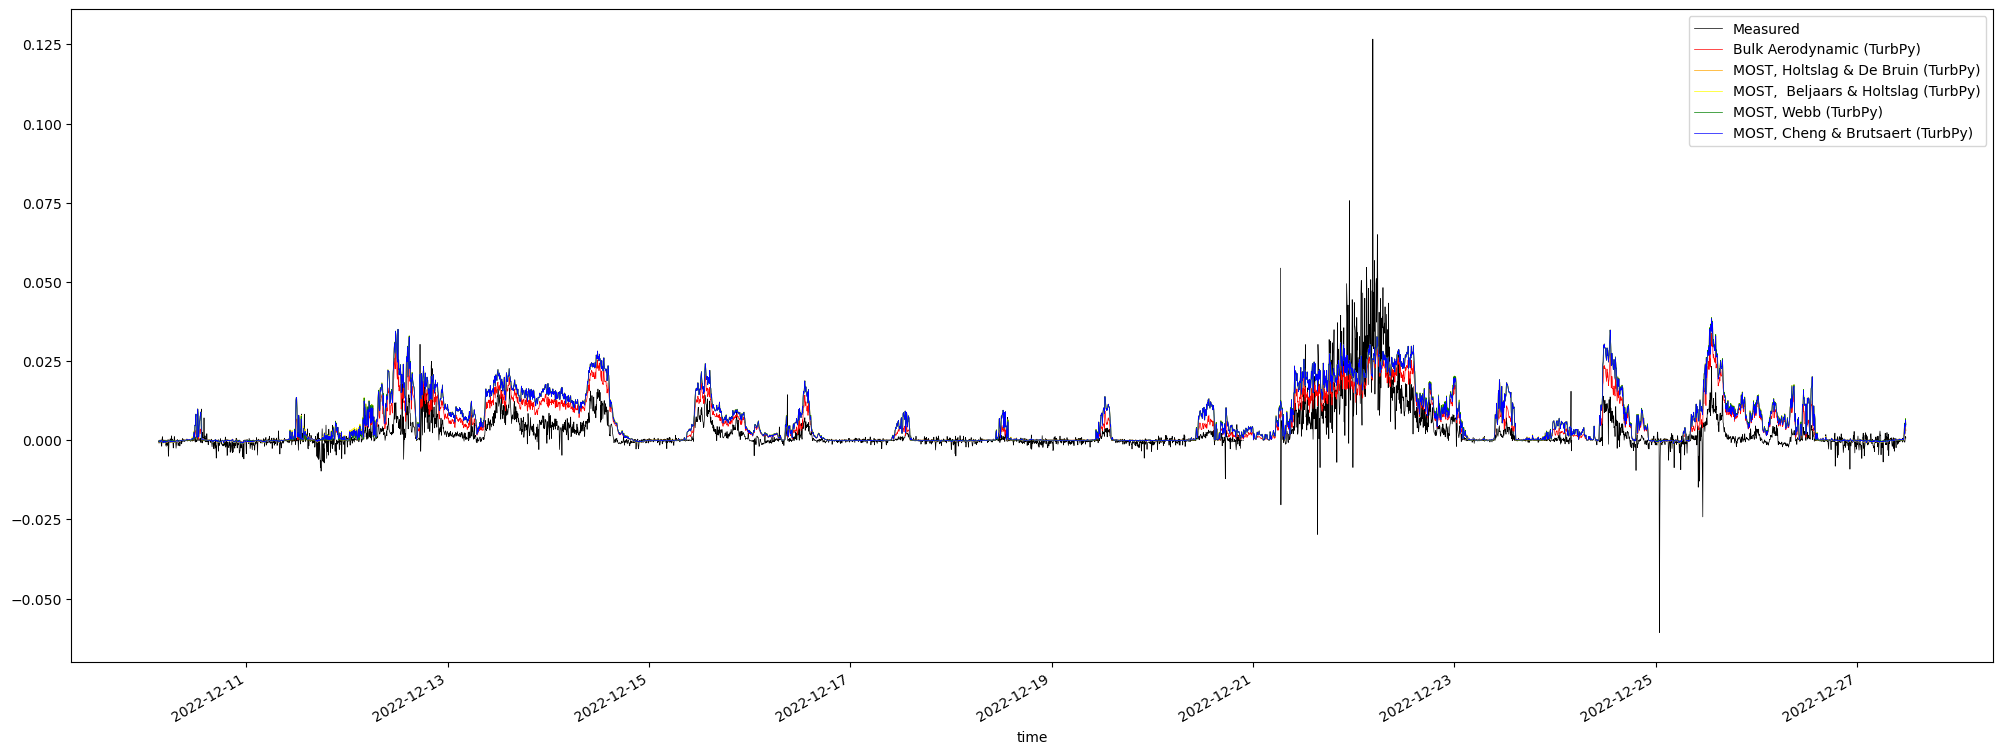

In [76]:
src = merged_df.iloc[3000:8000].copy()
plt.figure(figsize=(2*12.4, 2*4.8))
src.plot(x = 'time', y = 'w_h2o__3m_c',                             label = 'Measured', color='black', linewidth=0.5, ax = plt.gca())
src.plot(x = 'time', y = 'latent_heat_flux Standard',               label = 'Bulk Aerodynamic (TurbPy)', color='red', linewidth=0.5, ax = plt.gca())
src.plot(x = 'time', y = 'latent_heat_flux MO_HdB',                 label = 'MOST, Holtslag & De Bruin (TurbPy)', color='orange', linewidth=0.5, ax = plt.gca())
src.plot(x = 'time', y = 'latent_heat_flux MO (Beljaars/Holtslag)', label = 'MOST,  Beljaars & Holtslag (TurbPy)', color='yellow', linewidth=0.5, ax = plt.gca())
src.plot(x = 'time', y = 'latent_heat_flux MO (Webb - NoahMP)',     label = 'MOST, Webb (TurbPy)', color='green', linewidth=0.5, ax = plt.gca())
src.plot(x = 'time', y = 'latent_heat_flux MO (Cheng/Brutsaert)',   label = 'MOST, Cheng & Brutsaert (TurbPy)', color='blue', linewidth=0.5, ax = plt.gca())

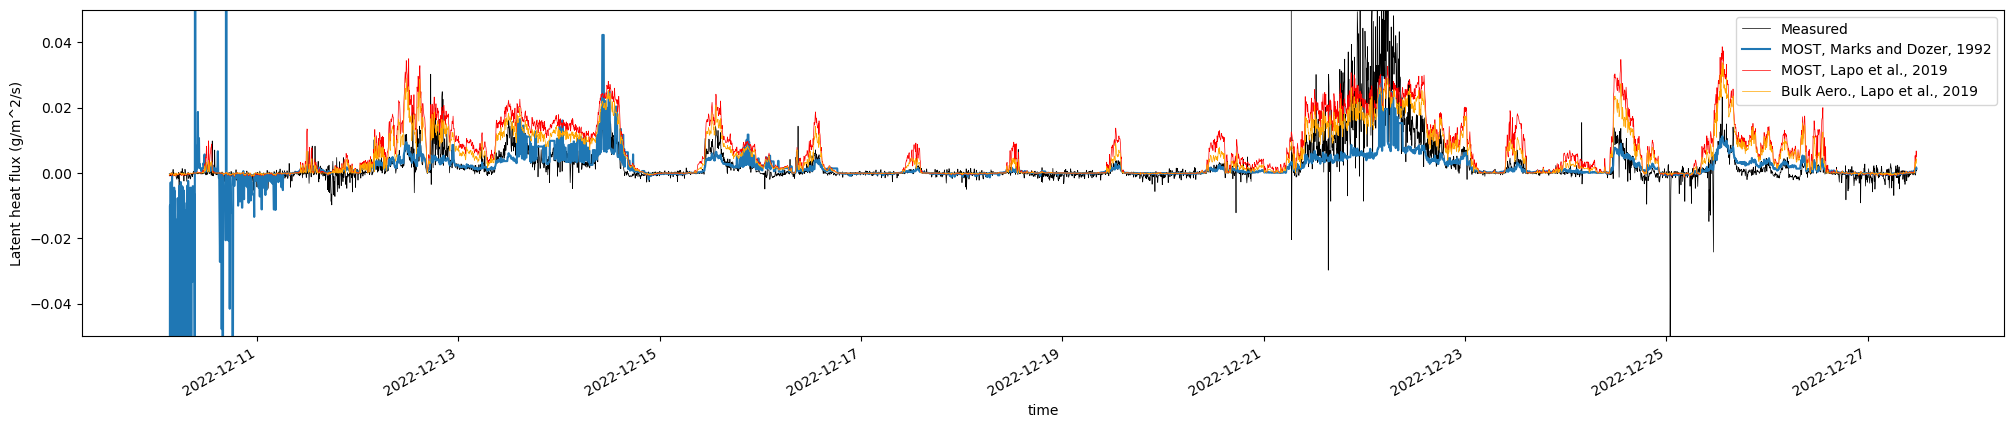

In [42]:
plt.figure(figsize=(2*12.4, 4.8))
merged_df.iloc[3000:8000].plot(x='time', y='w_h2o__3m_c',                       label='Measured', color='black', linewidth=0.5, ax = plt.gca())
merged_df.iloc[3000:8000].plot(x='time', y='latent_heat_flux',                  label='MOST, Marks and Dozer, 1992', ax = plt.gca())
merged_df.iloc[3000:8000].plot(x='time', y='latent_heat_flux turbpy',           label='MOST, Lapo et al., 2019', color='red', linewidth=0.5, ax = plt.gca())
merged_df.iloc[3000:8000].plot(x='time', y='latent_heat_flux turbpy standard',  label='Bulk Aero., Lapo et al., 2019', color='orange', linewidth=0.5, ax = plt.gca())

plt.ylim(-0.05, 0.05)
plt.ylabel("Latent heat flux (g/m^2/s)")
plt.legend()

# Try an iterative solution

As described here (page 6.6, https://atmos.washington.edu/~breth/classes/AS547/lect/lect6.pdf), using the functions outlined in the MOST scheme above.

Starting with an estimate of L, we solve for Phi_m, Phi_H, and Phi_E. Using these coefficients, we infer u_friction, H, and E, and thereby get a new estimate of L. The iteration is repeated until it converges (which it generally does). We can start the iteration by assuming neutral conditions (L = ∞).

## For one timestep

In [95]:
variable_set = variables_df.iloc[10001]

L_list = [1.0e24]
u_friction_list = [] 
H_list = [] 
E_list = [] 

ITERATIONS = 50

for i in range(0, 50):
    L = L_list[-1]
    Phi_m = most.stability_function_mass(3, L)
    Phi_H = most.stability_function_heat(3, L)
    Phi_E = most.stability_function_watervapor(3, L)
    u_friction = most.friction_velocity(variable_set['spd_3m_c'], 3, Phi_m)
    H = most.sensible_heat_flux(
        variable_set['Tpot_3m_c'], variable_set['Tsurfpot_rad_c'], 
            u_friction, variable_set['airdensity_3m_c'], 3, Phi_H)
    E = most.latent_heat_flux(
        variable_set['mixingratio_3m_c'], variable_set['Tsurfmixingratio_rad_c'], 
            u_friction, variable_set['airdensity_3m_c'], 3, Phi_E)
    L = most.obukhov_stability_length(
        u_friction, variable_set['airdensity_3m_c'], 
            H, variable_set['T_3m_c'], E)
    L_list.append(L)
    u_friction_list.append(u_friction)
    H_list.append(H)
    E_list.append(E)

In [96]:
print(L_list)
print(u_friction_list)
print(H_list)
print(E_list)

[1e+24, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.015730425558212743, 0.

## For the whole dataset

In [97]:
most = MOST()

In [98]:
L_solutions = []
u_friction_solutions = []
H_solutions = []
E_solutions = []

for i in range(0, len(variables_df)):
    
    variable_set = variables_df.iloc[i]

    if variable_set.hasnans:
        L_solutions.append(np.nan)
        u_friction_solutions.append(np.nan)
        H_solutions.append(np.nan)
        E_solutions.append(np.nan)
    
    else:

        L_list = [1.0e24]
        u_friction_list = [] 
        H_list = [] 
        E_list = [] 

        ITERATIONS = 50

        for i in range(0, 50):
            L = L_list[-1]
            Phi_m = most.stability_function_mass(3, L)
            Phi_H = most.stability_function_heat(3, L)
            Phi_E = most.stability_function_watervapor(3, L)
            u_friction = most.friction_velocity(variable_set['spd_3m_c'], 3, Phi_m)
            H = most.sensible_heat_flux(
                variable_set['Tpot_3m_c'], variable_set['Tsurfpot_rad_c'], 
                    u_friction, variable_set['airdensity_3m_c'], 3, Phi_H)
            E = most.latent_heat_flux(
                variable_set['mixingratio_3m_c'], variable_set['Tsurfmixingratio_rad_c'], 
                    u_friction, variable_set['airdensity_3m_c'], 3, Phi_E)
            L = most.obukhov_stability_length(
                u_friction, variable_set['airdensity_3m_c'], 
                    H, variable_set['T_3m_c'], E)
            L_list.append(L)
            u_friction_list.append(u_friction)
            H_list.append(H)
            E_list.append(E)

        # Assert that all variables converged
        assert np.isclose(L_list[-1], L_list[-2])
        assert np.isclose(u_friction_list[-1], u_friction_list[-2])
        assert np.isclose(H_list[-1], H_list[-2])
        assert np.isclose(E_list[-1], E_list[-2])
        
        L_solutions.append(L_list[-1])
        u_friction_solutions.append(u_friction_list[-1])
        H_solutions.append(H_list[-1])
        E_solutions.append(E_list[-1])

In [99]:
solutions_df = variables_df.copy()
solutions_df['L_solution'] = L_solutions
solutions_df['u_friction_solution'] = u_friction_solutions
solutions_df['H_solution'] = H_solutions
solutions_df['E_solution'] = E_solutions

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

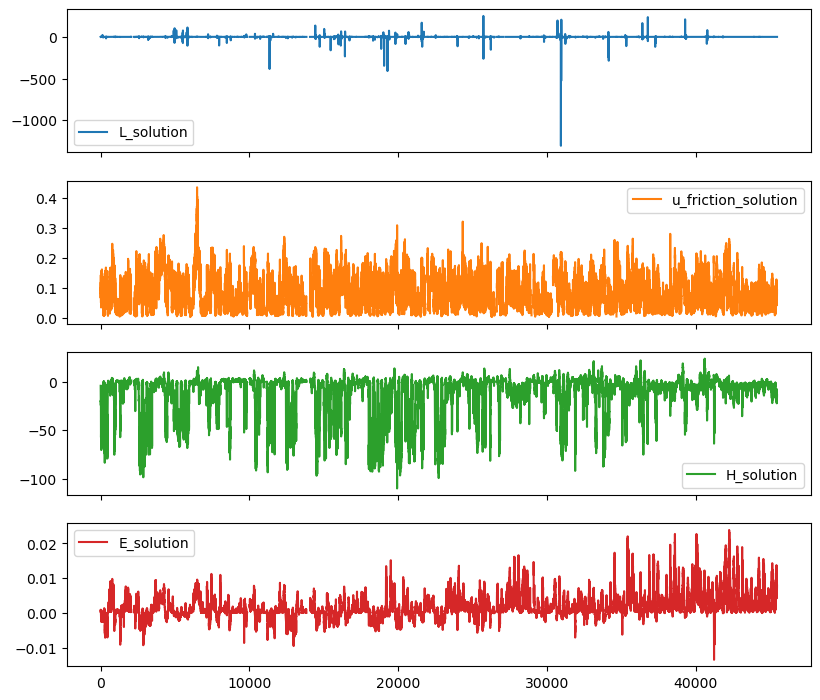

In [100]:
solutions_df[[
    'L_solution', 'u_friction_solution', 'H_solution', 'E_solution' 
]].plot(subplots=True, figsize=(9.6, 8.53))

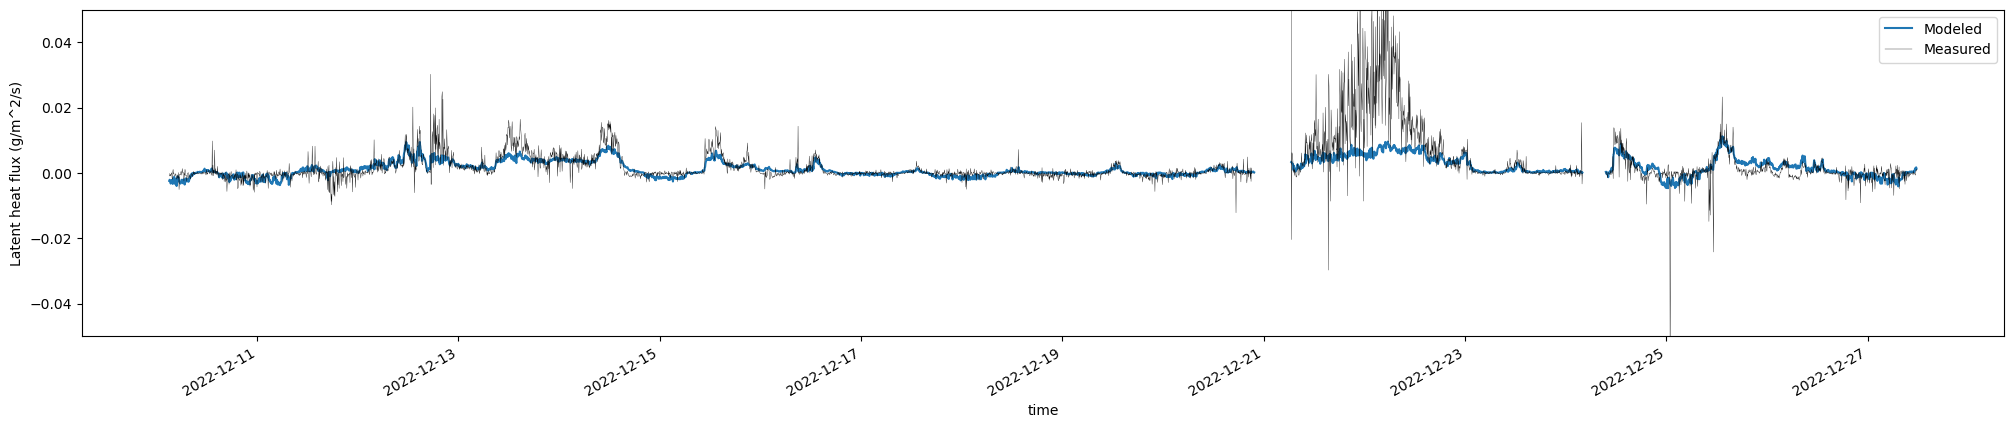

In [101]:
plt.figure(figsize=(24.8, 4.8))
solutions_df.iloc[3000:8000].plot(x='time', y='E_solution', label='Modeled', ax = plt.gca())
solutions_df.iloc[3000:8000].plot(x='time', y='w_h2o__3m_c', label='Measured', color='black', linewidth=0.25, ax = plt.gca())
plt.ylim(-0.05, 0.05)
plt.ylabel("Latent heat flux (g/m^2/s)")
plt.legend()

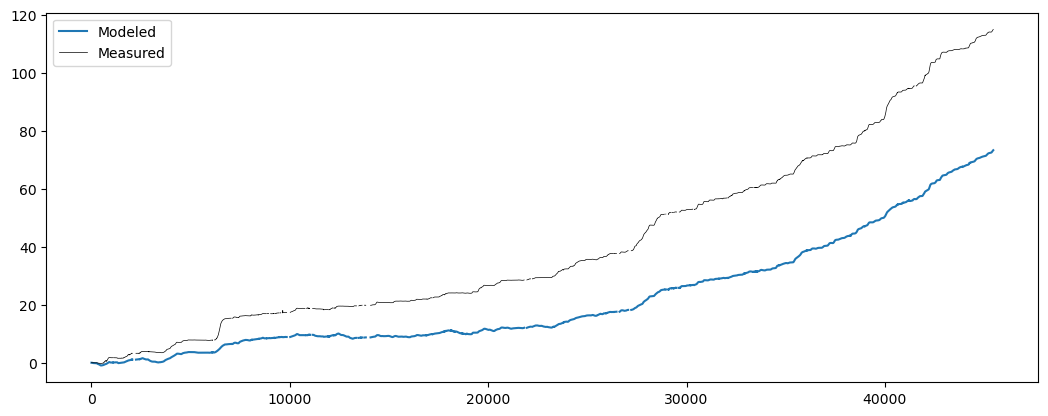

In [81]:
plt.figure(figsize=(12.8, 4.8))
solutions_df['E_solution'].cumsum().plot(label='Modeled')
solutions_df['w_h2o__3m_c'].cumsum().plot(label='Measured', color='black', linewidth=0.5)
plt.legend()

In [105]:
solutions_df['mixingratio_grad'] = (solutions_df['mixingratio_3m_c'] - solutions_df['Tsurfmixingratio_rad_c']) / 3

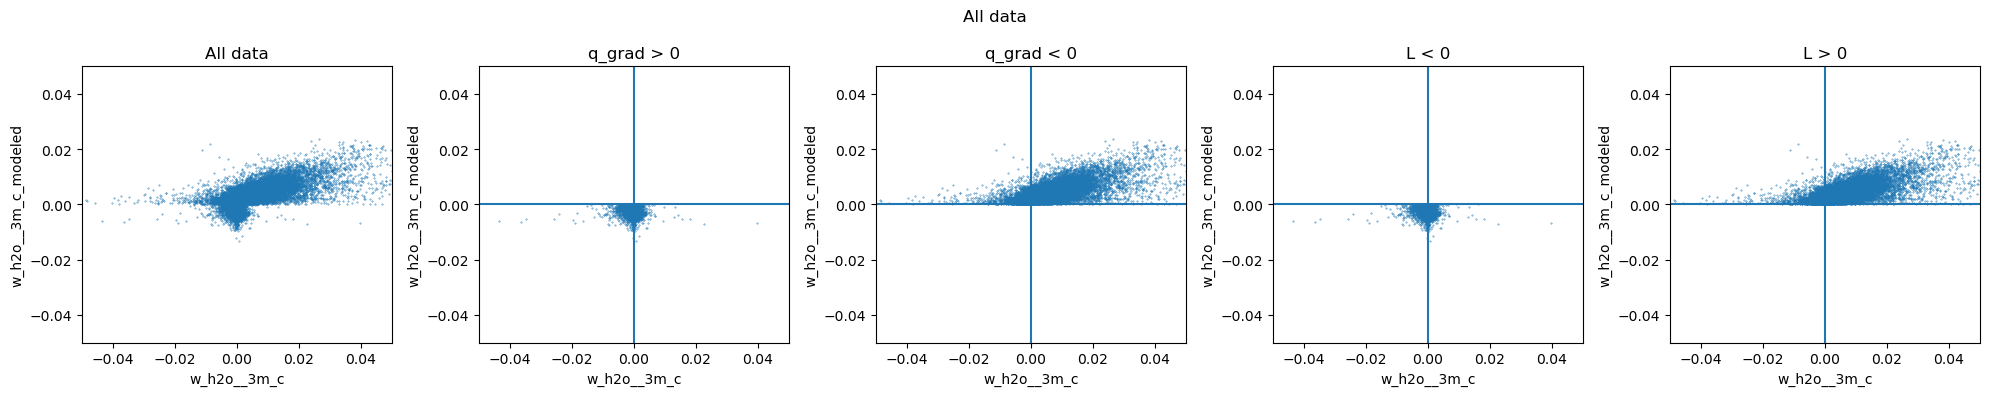

In [106]:
fig, axes = plt.subplots(1,5, figsize=(20,4))

# all data
axes[0].set_title("All data")
meas_src = solutions_df['w_h2o__3m_c'],
model_src = solutions_df['E_solution'],
axes[0].scatter(
    meas_src,
    model_src,
    s=0.1
)
axes[0].set_xlim(-0.05, 0.05)
axes[0].set_ylim(-0.05, 0.05)

# q gradient is positive (expected downward motion of water vapor)
axes[1].set_title("q_grad > 0")
src = solutions_df.copy()
src['w_h2o__3m_c_modeled'] = src['E_solution']
src = src.query("mixingratio_grad > 0")
axes[1].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[1].axvline(0)
axes[1].axhline(0)
axes[1].set_xlim(-0.05, 0.05)
axes[1].set_ylim(-0.05, 0.05)

# q gradient is negative (expected upward motion of water vapor)
axes[2].set_title("q_grad < 0")
src = solutions_df.copy()
src['w_h2o__3m_c_modeled'] = src['E_solution']
src = src.query("mixingratio_grad < 0")

axes[2].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[2].axvline(0)
axes[2].axhline(0)
axes[2].set_xlim(-0.05, 0.05)
axes[2].set_ylim(-0.05, 0.05)

# L < 0
axes[3].set_title("L < 0")
src = solutions_df.copy()
src['w_h2o__3m_c_modeled'] = src['E_solution']
src = src.query("L_solution < 0")

axes[3].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[3].axvline(0)
axes[3].axhline(0)
axes[3].set_xlim(-0.05, 0.05)
axes[3].set_ylim(-0.05, 0.05)

# L > 0
axes[4].set_title("L > 0")
src = solutions_df.copy()
src['w_h2o__3m_c_modeled'] = src['E_solution']
src = src.query("L_solution > 0")

axes[4].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[4].axvline(0)
axes[4].axhline(0)
axes[4].set_xlim(-0.05, 0.05)
axes[4].set_ylim(-0.05, 0.05)

for ax in axes:
    ax.set_xlabel('w_h2o__3m_c')
    ax.set_ylabel('w_h2o__3m_c_modeled')
plt.suptitle("All data")
plt.tight_layout()

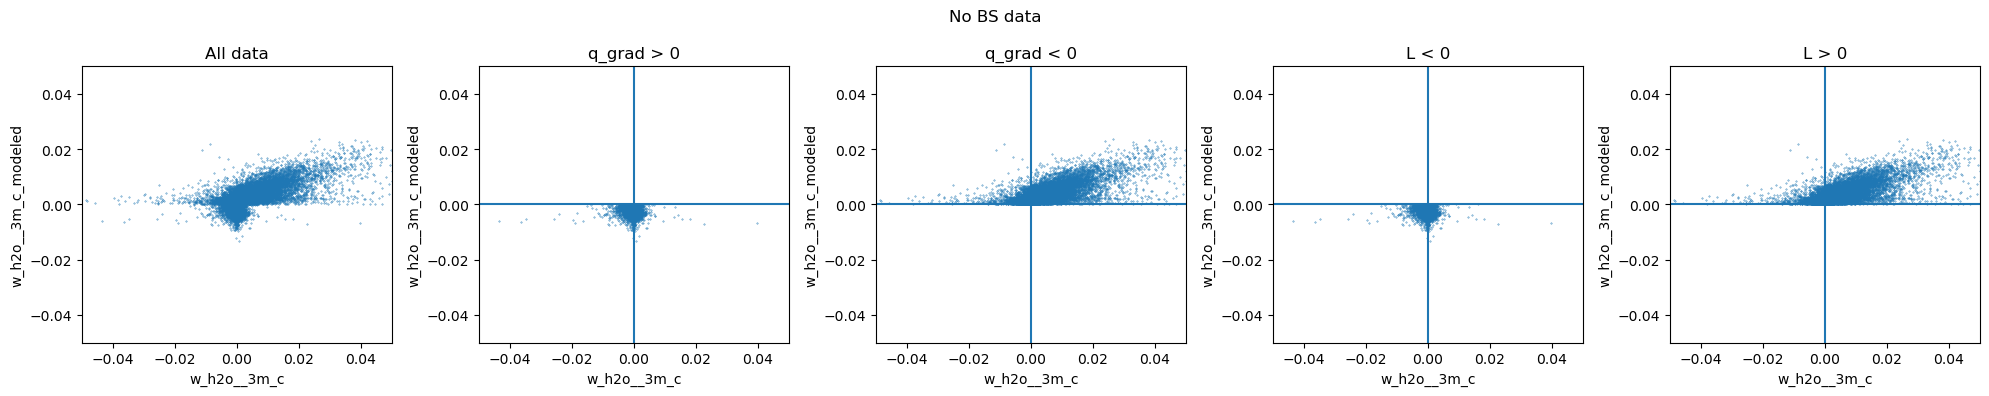

In [107]:
no_bs_times = tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").query("value == 0").time

solutions_df_src = solutions_df[solutions_df.time.isin(no_bs_times)]


fig, axes = plt.subplots(1,5, figsize=(20,4))

# all data
axes[0].set_title("All data")
meas_src = solutions_df_src['w_h2o__3m_c'],
model_src = solutions_df_src['E_solution'],
axes[0].scatter(
    meas_src,
    model_src,
    s=0.1
)
axes[0].set_xlim(-0.05, 0.05)
axes[0].set_ylim(-0.05, 0.05)

# q gradient is positive (expected downward motion of water vapor)
axes[1].set_title("q_grad > 0")
src = solutions_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['E_solution']
src = src.query("mixingratio_grad > 0")
axes[1].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[1].axvline(0)
axes[1].axhline(0)
axes[1].set_xlim(-0.05, 0.05)
axes[1].set_ylim(-0.05, 0.05)

# q gradient is negative (expected upward motion of water vapor)
axes[2].set_title("q_grad < 0")
src = solutions_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['E_solution']
src = src.query("mixingratio_grad < 0")

axes[2].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[2].axvline(0)
axes[2].axhline(0)
axes[2].set_xlim(-0.05, 0.05)
axes[2].set_ylim(-0.05, 0.05)

# L < 0
axes[3].set_title("L < 0")
src = solutions_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['E_solution']
src = src.query("L_solution < 0")

axes[3].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[3].axvline(0)
axes[3].axhline(0)
axes[3].set_xlim(-0.05, 0.05)
axes[3].set_ylim(-0.05, 0.05)

# L > 0
axes[4].set_title("L > 0")
src = solutions_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['E_solution']
src = src.query("L_solution > 0")

axes[4].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[4].axvline(0)
axes[4].axhline(0)
axes[4].set_xlim(-0.05, 0.05)
axes[4].set_ylim(-0.05, 0.05)

for ax in axes:
    ax.set_xlabel('w_h2o__3m_c')
    ax.set_ylabel('w_h2o__3m_c_modeled')
plt.suptitle("No BS data")
plt.tight_layout()